In [1]:
from skimage import io, data
from skimage import filters, measure
import napari
from scipy import ndimage as ndi
import numpy as np
from PIL import Image
from aicsimageio import AICSImage, imread
import trackpy as tp

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
viewer = napari.Viewer(title='t3D_trackpy_postptoj')

C:\Users\hkqur\miniconda3\envs\devbio_2\lib\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
21-Aug-24 14:31:20 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 640x510+1256+579 (frame: 658x557+1247+541) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 802x639+1257+586 (frame: 820x686+1248+548) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)


In [3]:
analymage_Post = AICSImage('C:/Users/hkqur/Documents/napari/eb3/2024-02-09/fast/eb3_lifeact_58hrs_at_26C_e3_fast_proj-01-Airyscan Processing-17.czi')
print(analymage_Post.shape)

(114, 1, 26, 332, 332)


In [4]:
imagoPP_ch1 = analymage_Post.data[:,0,:,:,:]



In [5]:
viewer.add_image(imagoPP_ch1, name='eb3-GFP',colormap='green',blending='additive')
viewer.layers['eb3-GFP'].scale=[6,1,1]

21-Aug-24 14:31:37 - napari_bleach_correct.modules.exponential - INFO     - R-squared value for fitting a bi-exponential curve: 0.9995509942497519


In [6]:
viewer.layers['eb3-GFP Corrected (Exponential Curve Method)'].scale=[6,1,1]

In [7]:
max_z_fast = viewer.layers['eb3-GFP Corrected (Exponential Curve Method)'].data

###TRACKING

In [8]:
batch_track = tp.batch(max_z_fast[:17],diameter=(9,51,51), minmass=400, separation=(5,17,17), noise_size=(4,4,4), percentile=40)

Frame 0: 38 features


MemoryError: 

C:\Users\hkqur\miniconda3\envs\napdevbio\lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

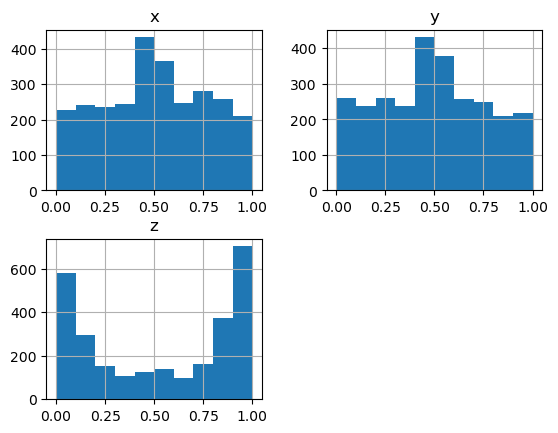

In [106]:
tp.subpx_bias(batch_track)

In [107]:
batch_track.head

<bound method NDFrame.head of               z           y           x          mass    size_z     size_y  \
0      5.566386  429.390531  230.101984  4.777346e+06  3.033162  20.036987   
1      6.547100   76.202057  235.886494  8.212674e+06  2.963385  12.885868   
2      6.421198   82.096383  195.482427  5.600873e+06  2.914140   6.791179   
3      6.536889  213.484213  190.427630  3.403953e+06  2.492383  22.024673   
4      6.335207  318.412897  236.763296  8.939575e+06  3.241487  15.028858   
...         ...         ...         ...           ...       ...        ...   
2733  68.545148  405.108108  307.046694  1.315926e+05  3.247989  15.148448   
2734  69.486675   41.750127   33.530489  4.409812e+06  3.016536  20.848202   
2735  69.515503  183.975807   75.799032  2.094949e+06  2.749892  19.329876   
2736  68.579142  449.058585  157.859133  3.144623e+05  2.806516  20.823299   
2737  69.444450  341.088988  193.760899  7.653060e+05  3.079513  17.474961   

         size_x  ecc       signal

(array([ 35., 227., 724., 700., 492., 268., 106.,  84.,  49.,   8.,   5.,
          7.,   9.,   5.,   6.,   3.,   8.,   0.,   0.,   2.]),
 array([1.60401500e+06, 1.23002305e+07, 2.29964460e+07, 3.36926615e+07,
        4.43888770e+07, 5.50850925e+07, 6.57813080e+07, 7.64775235e+07,
        8.71737390e+07, 9.78699545e+07, 1.08566170e+08, 1.19262386e+08,
        1.29958601e+08, 1.40654816e+08, 1.51351032e+08, 1.62047248e+08,
        1.72743463e+08, 1.83439678e+08, 1.94135894e+08, 2.04832110e+08,
        2.15528325e+08]),
 <BarContainer object of 20 artists>)

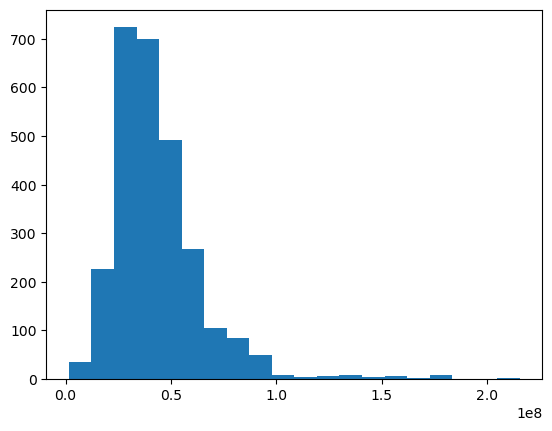

In [108]:
fig,ax=plt.subplots()
ax.hist(batch_track['raw_mass'], bins=20)

In [109]:
batch_track.columns

Index(['z', 'y', 'x', 'mass', 'size_z', 'size_y', 'size_x', 'ecc', 'signal',
       'raw_mass', 'ep_z', 'ep_y', 'ep_x', 'frame'],
      dtype='object')

In [110]:
batch_track['id'] = np.arange(0,len(batch_track))

In [111]:
batch_track_reorg=batch_track[["id","frame","z","y","x"]]

In [112]:
batch_track_reorg.head

<bound method NDFrame.head of         id  frame          z           y           x
0        0      0   5.566386  429.390531  230.101984
1        1      0   6.547100   76.202057  235.886494
2        2      0   6.421198   82.096383  195.482427
3        3      0   6.536889  213.484213  190.427630
4        4      0   6.335207  318.412897  236.763296
...    ...    ...        ...         ...         ...
2733  2733     16  68.545148  405.108108  307.046694
2734  2734     16  69.486675   41.750127   33.530489
2735  2735     16  69.515503  183.975807   75.799032
2736  2736     16  68.579142  449.058585  157.859133
2737  2737     16  69.444450  341.088988  193.760899

[2738 rows x 5 columns]>

In [113]:
t = tp.link(batch_track_reorg,search_range=(5,15,15),memory=5)

Frame 16: 195 trajectories present.


In [114]:
t.head()

,id,frame,z,y,x,particle
0,0,0,5.566386,429.390531,230.101984,0
99,99,0,47.053657,132.628196,202.116701,1
100,100,0,46.975020,210.041930,222.738276,2
101,101,0,47.447811,278.688734,58.160233,3
102,102,0,46.960472,305.678692,133.209679,4


In [115]:
t_filter=tp.filter_stubs(t,4)

In [116]:
t_filter.columns

Index(['id', 'frame', 'z', 'y', 'x', 'particle'], dtype='object')

In [117]:
t_filter_reorg = t_filter[['particle','frame','z','y','x']]

In [118]:
viewer.add_tracks(t_filter_reorg,name='tracks_T')

<Tracks layer 'tracks_T' at 0x29d8df09af0>

In [119]:
viewer.layers['tracks_T'].scale=[6,1,1]

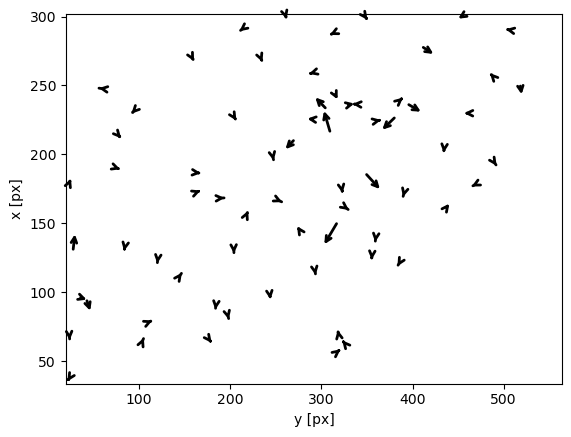

In [124]:
track_vector=tp.plot_displacements(t_filter,1,10,pos_columns=['y','x'])